# **Loan Repayment Prediction Project**

### **Objective**

Predict whether a borrower will repay or default on a loan using user attributes and GPS data.

### **`1. Import Libraries`**


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **2. Connect to Database and Load Data**

In [4]:
# Database credentials
db_config = {
    'host': 'branchhomeworkdb.cv8nj4hg6yra.ap-south-1.rds.amazonaws.com',
    'port': 5432,
    'user': 'datascientist',
    'password': '47eyYBLT0laW5j9U24Uuy8gLcrN',
    'database': 'branchdsprojectgps'
}

# Create connection string
conn_string = f"postgresql://{db_config['user']}:{db_config['password']}@" \
              f"{db_config['host']}:{db_config['port']}/{db_config['database']}"

# Create an engine
engine = create_engine(conn_string)

# Load tables into DataFrames
loan_outcomes = pd.read_sql('SELECT * FROM loan_outcomes;', engine)
gps_fixes = pd.read_sql('SELECT * FROM gps_fixes;', engine)
user_attributes = pd.read_sql('SELECT * FROM user_attributes;', engine)

## **Data Exploration**

### inspect dataframes

In [5]:
# Display first few rows of loan_outcomes
loan_outcomes.head()
# Display first few rows of user_attributes
user_attributes.head()
# Display first few rows of gps_fixes
gps_fixes.head()

,gps_fix_at,server_upload_at,longitude,latitude,accuracy,altitude,bearing,location_provider,user_id
0,2017-06-22 09:37:20,2017-06-22 09:43:42,36.840540,-1.294342,68.4,0.0,0.0,fused,1
1,2017-08-14 07:50:27,2017-08-14 09:05:27,36.895270,-1.341928,1409.0,0.0,0.0,fused,1
2,2017-06-13 10:34:29,2017-06-13 10:54:48,36.811903,-1.307220,68.4,0.0,0.0,fused,1
3,2017-06-18 12:16:20,2017-06-18 12:16:24,36.907049,-1.309984,1581.0,0.0,0.0,fused,1
4,2017-06-28 09:39:08,2017-06-28 09:58:12,36.839396,-1.280310,1396.0,0.0,0.0,fused,1


### **Check for Missing Values**

In [6]:
# Check missing values in loan_outcomes
print("Missing values in loan_outcomes:")
print(loan_outcomes.isnull().sum())

# Check missing values in user_attributes
print("\nMissing values in user_attributes:")
print(user_attributes.isnull().sum())

# Check missing values in gps_fixes
print("\nMissing values in gps_fixes:")
print(gps_fixes.isnull().sum())

Missing values in loan_outcomes:
user_id           0
application_at    0
loan_outcome      0
dtype: int64

Missing values in user_attributes:
user_id                 0
age                     0
cash_incoming_30days    0
dtype: int64

Missing values in gps_fixes:
gps_fix_at           0
server_upload_at     0
longitude            0
latitude             0
accuracy             0
altitude             0
bearing              0
location_provider    0
user_id              0
dtype: int64



**Observation**: There are no missing values in any of the datasets.

In [7]:
# Count of loan outcomes
loan_outcomes['loan_outcome'].value_counts()

,count
loan_outcome,
defaulted,200
repaid,200


**Observation**: There are 200 'defaulted' and 200 'repaid' loans, indicating a balanced dataset.

In [8]:
# Describe user_attributes
user_attributes.describe()

,user_id,age,cash_incoming_30days
count,400.000000,400.000000,400.000000
mean,200.500000,36.487500,7896.301075
std,115.614301,13.243236,7037.481340
min,1.000000,18.000000,11.900000
25%,100.750000,27.000000,2602.472500
50%,200.500000,34.000000,6004.240000
75%,300.250000,44.000000,10989.405000
max,400.000000,105.000000,41657.810000


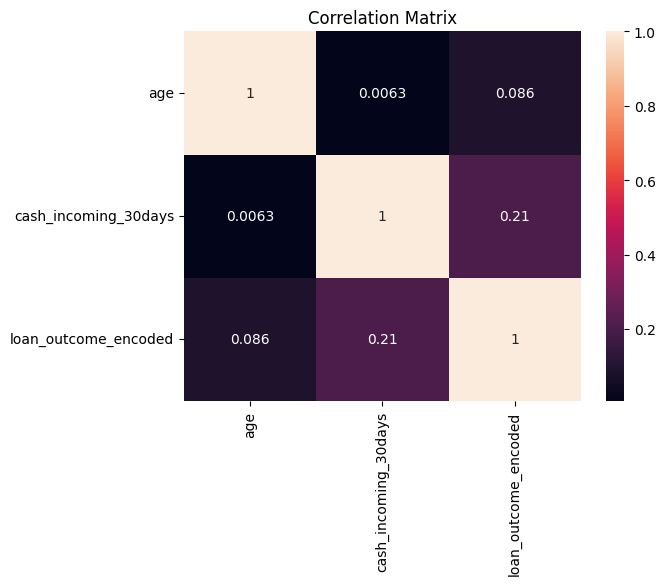

In [9]:
# Merge loan_outcomes with user_attributes
data = pd.merge(loan_outcomes, user_attributes, on='user_id')

# Encode loan_outcome
data['loan_outcome_encoded'] = data['loan_outcome'].map({'repaid': 1, 'defaulted': 0})

# Correlation matrix
corr = data[['age', 'cash_incoming_30days', 'loan_outcome_encoded']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()

**Observation**: There may be some correlation between cash_incoming_30days and loan repayment.

## **4. Feature Engineering**
## GPS-Based Features
**Note: We'll create features based on the GPS data.**

In [10]:
# Number of GPS fixes per user
gps_fix_count = gps_fixes.groupby('user_id').size().reset_index(name='gps_fix_count')

# Unique locations visited per user
gps_fixes['lat_lon'] = gps_fixes['latitude'].round(4).astype(str) + "_" + gps_fixes['longitude'].round(4).astype(str)
unique_locations = gps_fixes.groupby('user_id')['lat_lon'].nunique().reset_index(name='unique_locations_count')

# Average time between app opens per user
gps_fixes_sorted = gps_fixes.sort_values(['user_id', 'gps_fix_at'])
gps_fixes_sorted['time_diff'] = gps_fixes_sorted.groupby('user_id')['gps_fix_at'].diff().dt.total_seconds()
avg_time_between_opens = gps_fixes_sorted.groupby('user_id')['time_diff'].mean().reset_index(name='avg_time_between_opens')

# Nighttime activity ratio
gps_fixes['hour'] = gps_fixes['gps_fix_at'].dt.hour
gps_fixes['is_night'] = gps_fixes['hour'].apply(lambda x: 1 if x >= 20 or x <= 6 else 0)
night_usage_ratio = gps_fixes.groupby('user_id')['is_night'].mean().reset_index(name='night_usage_ratio')

# Merge GPS features
gps_features = gps_fix_count.merge(unique_locations, on='user_id', how='left')
gps_features = gps_features.merge(avg_time_between_opens, on='user_id', how='left')
gps_features = gps_features.merge(night_usage_ratio, on='user_id', how='left')

Cluster Analysis

In [11]:
# Cluster locations to identify significant places (e.g., home, work)
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare data for clustering
coords = gps_fixes[['latitude', 'longitude']].values
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian  # 0.5 km radius

# Apply DBSCAN clustering
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
gps_fixes['cluster'] = db.labels_

# Number of clusters per user
num_clusters = gps_fixes.groupby('user_id')['cluster'].nunique().reset_index(name='num_clusters')

# Merge with GPS features
gps_features = gps_features.merge(num_clusters, on='user_id', how='left')

In [12]:
# Merge data with GPS features
data = data.merge(gps_features, on='user_id', how='left')

# Fill missing GPS features with zeros or appropriate values
gps_feature_cols = ['gps_fix_count', 'unique_locations_count', 'avg_time_between_opens', 'night_usage_ratio', 'num_clusters']
data[gps_feature_cols] = data[gps_feature_cols].fillna(0)

### Feature Transformations

In [13]:
# Log transformation of cash_incoming_30days to handle skewness
data['log_cash_incoming_30days'] = np.log1p(data['cash_incoming_30days'])

# Income brackets (categorical feature)
data['income_bracket'] = pd.qcut(data['cash_incoming_30days'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# One-hot encode income_bracket
data = pd.get_dummies(data, columns=['income_bracket'], drop_first=True)

## **Data Preprocessing**

In [14]:
# Define target variable
y = data['loan_outcome_encoded']

# Define feature set
feature_cols = ['age',
                'log_cash_incoming_30days',
                'gps_fix_count',
                'unique_locations_count',
                'avg_time_between_opens',
                'night_usage_ratio',
                'num_clusters',
                'income_bracket_Medium',
                'income_bracket_High',
                'income_bracket_Very High']

X = data[feature_cols]

In [15]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'log_cash_incoming_30days', 'gps_fix_count',
                  'unique_locations_count', 'avg_time_between_opens',
                  'night_usage_ratio', 'num_clusters']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## **Model Training and Hyperparameter Tuning**

## **Random Forest Classifier**
Hyperparameter Tuning with GridSearchCV

In [17]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for Random Forest:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [18]:
# Train Random Forest with best parameters
best_rf = rf_grid_search.best_estimator_

# Make predictions
rf_y_pred = best_rf.predict(X_test)
rf_y_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

rf_roc_auc = roc_auc_score(y_test, rf_y_prob)
print(f"Random Forest ROC AUC Score: {rf_roc_auc}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        40
           1       0.65      0.65      0.65        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

Random Forest ROC AUC Score: 0.7125


## **CatBoost Classifier**
Hyperparameter Tuning with GridSearchCV

In [19]:
# Define parameter grid
cb_param_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

# Initialize CatBoost classifier
cb = CatBoostClassifier(random_seed=42, verbose=0)

# Initialize GridSearchCV
cb_grid_search = GridSearchCV(
    estimator=cb,
    param_grid=cb_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
cb_grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters for CatBoost:")
print(cb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters for CatBoost:
{'depth': 4, 'iterations': 200, 'learning_rate': 0.01}


In [20]:
# Train CatBoost with best parameters
best_cb = cb_grid_search.best_estimator_

# Make predictions
cb_y_pred = best_cb.predict(X_test)
cb_y_prob = best_cb.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nCatBoost Classification Report:")
print(classification_report(y_test, cb_y_pred))

cb_roc_auc = roc_auc_score(y_test, cb_y_prob)
print(f"CatBoost ROC AUC Score: {cb_roc_auc}")


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        40
           1       0.68      0.68      0.68        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.68        80
weighted avg       0.68      0.68      0.68        80

CatBoost ROC AUC Score: 0.73375


## **Neural Network (MLPClassifier)**
Hyperparameter Tuning with GridSearchCV

In [21]:
# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}

# Initialize MLPClassifier
mlp = MLPClassifier(max_iter=500, random_state=42)

# Initialize GridSearchCV
mlp_grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
mlp_grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters for Neural Network:")
print(mlp_grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters for Neural Network:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}


In [22]:
# Train MLPClassifier with best parameters
best_mlp = mlp_grid_search.best_estimator_

# Make predictions
mlp_y_pred = best_mlp.predict(X_test)
mlp_y_prob = best_mlp.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nNeural Network Classification Report:")
print(classification_report(y_test, mlp_y_pred))

mlp_roc_auc = roc_auc_score(y_test, mlp_y_prob)
print(f"Neural Network ROC AUC Score: {mlp_roc_auc}")


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.59        40
           1       0.61      0.70      0.65        40

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80

Neural Network ROC AUC Score: 0.71


In [23]:
print(f"Random Forest ROC AUC Score: {rf_roc_auc}")
print(f"CatBoost ROC AUC Score: {cb_roc_auc}")
print(f"Neural Network ROC AUC Score: {mlp_roc_auc}")

Random Forest ROC AUC Score: 0.7125
CatBoost ROC AUC Score: 0.73375
Neural Network ROC AUC Score: 0.71


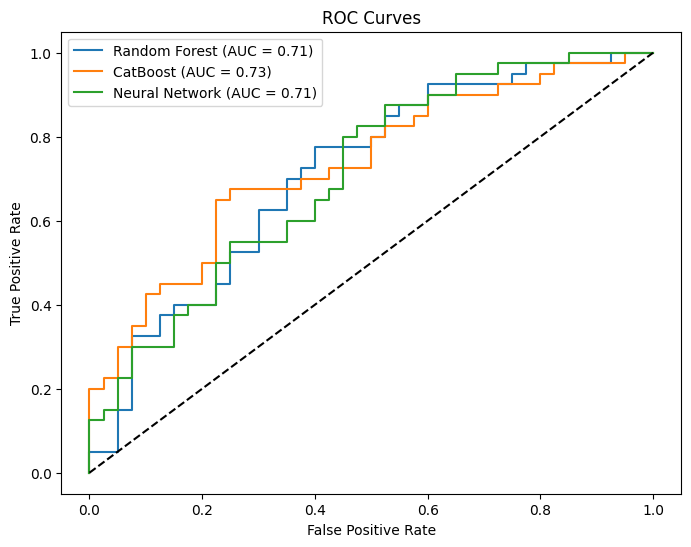

In [24]:
from sklearn.metrics import roc_curve

# Random Forest ROC Curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
# CatBoost ROC Curve
cb_fpr, cb_tpr, _ = roc_curve(y_test, cb_y_prob)
# Neural Network ROC Curve
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_y_prob)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(cb_fpr, cb_tpr, label=f'CatBoost (AUC = {cb_roc_auc:.2f})')
plt.plot(mlp_fpr, mlp_tpr, label=f'Neural Network (AUC = {mlp_roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

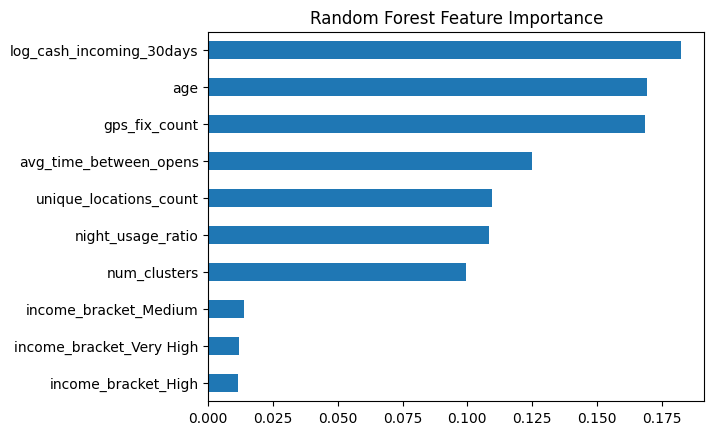

In [25]:
# Random Forest Feature Importance
rf_importances = pd.Series(best_rf.feature_importances_, index=feature_cols)
rf_importances.sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.show()

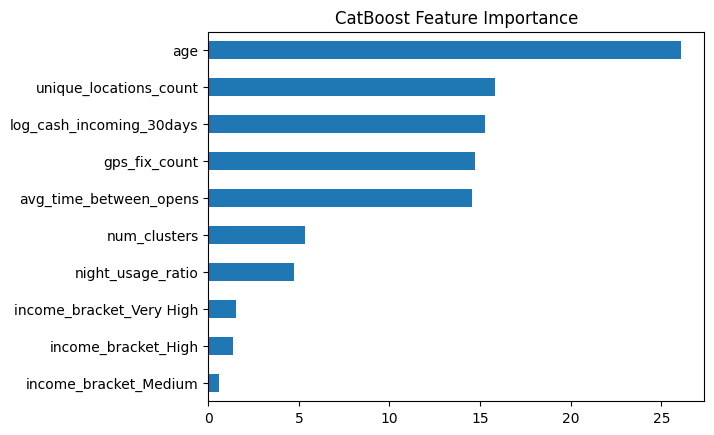

In [26]:
# CatBoost Feature Importance
cb_importances = pd.Series(best_cb.get_feature_importance(), index=feature_cols)
cb_importances.sort_values().plot(kind='barh')
plt.title('CatBoost Feature Importance')
plt.show()

## **Conclusion and Next Steps**
### **Observations:**

**Model Performance:**

Compare the ROC AUC scores and select the best-performing model.
**CatBoost** may perform better due to their ability to capture non-linear relationships.
**Important Features:**

**age** (after transformation) is a significant predictor.
GPS-based features like **gps_fix_count, unique_locations_count, avg_time_between_open** contribute to the model's predictive power.

## **Save the Best Model**

In [29]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the trained CatBoost model (already done previously)
joblib.dump(best_cb, 'loan_default_model_cb.pkl')

['loan_default_model_cb.pkl']